In [1]:
import ctypes
import serial
from picosdk.ps3000a import ps3000a as ps
from picosdk.functions import mV2adc, adc2mV, assert_pico_ok
import numpy as np
import matplotlib.pyplot as plt
    
from pwn import *
from tqdm import tqdm
import random
import time

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from Trace_processor_pico3000a import TraceProcessor

The ps3000a.dll dynamic link library (DLL) in the SDK allows you to program any supported oscilloscope using standard C function calls.  

A typical program for capturing data consists of the following steps:  
- Open the scope unit.  
- Set up the input channels with the required voltage ranges and coupling type.  
- Set up triggering.  
- Start capturing data. (See Sampling modes, where programming is discussed in more detail.)  
- Wait until the scope unit is ready.  
- Stop capturing data.  
- Copy data to a buffer.  
- Close the scope unit.  

In [2]:
# Step 1: Open the scope unit
# Create chan and status ready for use

status = {}
chandle = ctypes.c_int16()

# Opens the device/s
status["openunit"] = ps.ps3000aOpenUnit(ctypes.byref(chandle), None)

try:
    assert_pico_ok(status["openunit"])
except:
    
    print("pico not ok?")
    # powerstate becomes the status number of openunit
    powerstate = status["openunit"]

    # If powerstate is the same as 282 then it will run this if statement
    if powerstate == 282:
        # Changes the power input to "PICO_POWER_SUPPLY_NOT_CONNECTED"
        status["ChangePowerSource"] = ps.ps3000aChangePowerSource(chandle, 282)
        # If the powerstate is the same as 286 then it will run this if statement
    elif powerstate == 286:
        # Changes the power input to "PICO_USB3_0_DEVICE_NON_USB3_0_PORT"
        status["ChangePowerSource"] = ps.ps3000aChangePowerSource(chandle, 286)
    else:
        raise

    assert_pico_ok(status["ChangePowerSource"])


print(status["openunit"])

0


In [3]:
# Step 2.a: Input channel parameters

#ps3000a.PS3000A_RANGE = make_enum([
#     "PS3000A_10MV",
#     "PS3000A_20MV",
#     "PS3000A_50MV",
#     "PS3000A_100MV",
#     "PS3000A_200MV",
#     "PS3000A_500MV",
#     "PS3000A_1V",
#     "PS3000A_2V",
#     "PS3000A_5V",
#     "PS3000A_10V",
#     "PS3000A_20V",
#     "PS3000A_50V",
#     "PS3000A_MAX_RANGES",
# ])

## Set up parameters of channel A
channel_A = ps.PS3000A_CHANNEL["PS3000A_CHANNEL_A"]
enabled_A = 1
coupling_type_A = ps.PS3000A_COUPLING["PS3000A_DC"] # DC
chARange = ps.PS3000A_RANGE["PS3000A_5V"] # amplitude
analogue_offset_A = 0.0

# Set up parameters of channel B 
channel_B = ps.PS3000A_CHANNEL["PS3000A_CHANNEL_B"]
enabled_B = 1
coupling_type_B = ps.PS3000A_COUPLING["PS3000A_DC"] # DC
chBRange = ps.PS3000A_RANGE["PS3000A_50MV"] # amplitude AES
chBRange = ps.PS3000A_RANGE["PS3000A_200MV"] # amplitude ECDSA
analogue_offset_B = 0.0

# set up channel A
status["setChA"] = ps.ps3000aSetChannel(chandle, channel_A, enabled_A, coupling_type_A, chARange, analogue_offset_A)
assert_pico_ok(status["setChA"])

# set up channel B
status["setChB"] = ps.ps3000aSetChannel(chandle, channel_B, enabled_B, coupling_type_B, chBRange, analogue_offset_B)
assert_pico_ok(status["setChB"])

# find maximum ADC count value
# handle = chandle
# pointer to value = ctypes.byref(maxADC)
maxADC = ctypes.c_int16()
status["maximumValue"] = ps.ps3000aMaximumValue(chandle, ctypes.byref(maxADC))
assert_pico_ok(status["maximumValue"])

In [4]:
# Step 2.b: Time axis parameters

# Setting the number of sample to be collected
# TOTAL_SAMPLE_NUM = 500_000 # 50_000 # 32_000_000 
# TOTAL_SAMPLE_NUM = 50_000 # for AES
# TOTAL_SAMPLE_NUM = 250_000 # for AES & random delay
TOTAL_SAMPLE_NUM = 32_000_000 # 6_400_000 # 32_000_000 # for ECDSA
# TOTAL_SAMPLE_NUM = 32_000_000 # ~64ms, and aes(init+ecnrypt) is ~ 90us
shift = 0
if shift <= 0:  # left shift
    preTriggerSamples = 0
    postTriggerSamples = TOTAL_SAMPLE_NUM + np.abs(shift)
    left_shift = np.abs(shift)
else:           # right shift
    preTriggerSamples = shift
    postTriggerSamples = TOTAL_SAMPLE_NUM - np.abs(shift)
    left_shift = 0
maxsamples = TOTAL_SAMPLE_NUM # ?

In [5]:
# Step 2.c: Sampling Rate Parameters

# Gets timebase innfomation parameters
# SAMPLING_RATE = '500M' # AES
SAMPLING_RATE = "62.5M" # "31.25M" # '12.5M' # "62.5M" # ECDSA
# sampling_rate = "1G" # ?

sampling_rate_to_timebase = {
    "1G"    : 0,
    "500M"  : 1,
    "250M"  : 2,
    "125M"  : 3,
    "62.5M" : 4,
    "31.25M": 6,
    "25M"   : 7,
    "12.5M" : 12,
    "6.25M" : 22,
    "5M"    : 27,
    "2.5M"  : 52,
    "1.25M" : 102,
    "1M"    : 127,
    "0.5M"  : 252,
    "0.1M"  : 1252
}


timebase = sampling_rate_to_timebase[SAMPLING_RATE]
timeIntervalns = ctypes.c_float()
returnedMaxSamples = ctypes.c_int16()
status["GetTimebase"] = ps.ps3000aGetTimebase2(chandle, timebase, maxsamples, ctypes.byref(timeIntervalns), 1, ctypes.byref(returnedMaxSamples), 0)
assert_pico_ok(status["GetTimebase"])
print('timeIntervalns', timeIntervalns.value)

timeIntervalns 16.0


In [6]:
# Step 3: Trigger parameters
# how many samples to SKIP
# TRIG_DELAY = 0 # AES
TRIG_DELAY = 0 # ECDSA

trigger_source = ps.PS3000A_CHANNEL["PS3000A_EXTERNAL"]
trigger_enable = 1

# The PicoScope 3000 Series D models have an external trigger input (marked Ext). This external trigger input is scaled to a 16-bit value as follows:
# external max value, 5v  -- +32 767 / 0x7FFF
#                   , 0V  -- 0 / 0x00
# external min value, -5v -- –32 767 / 0x8001
trigger_source = ps.PS3000A_CHANNEL["PS3000A_EXTERNAL"]
trigger_enable = 1
# 1.5V trigger
threshold_mV = 1500
threshold = int(32767 * 1500 / 5000)
direction = ps.PS3000A_DIGITAL_DIRECTION["PS3000A_DIGITAL_DIRECTION_HIGH"] # Rising edge
autoTrigger_ms = 0 # ?

# Sets up single trigger
status["trigger"] = ps.ps3000aSetSimpleTrigger(chandle, trigger_enable, trigger_source, threshold, direction, TRIG_DELAY, autoTrigger_ms)
assert_pico_ok(status["trigger"])

In [7]:
# Step 4: Trace Saving Parameters
TRACE_NUM = 2 # how many traces do we need?
board = 'nrf52840'
# algo = 'tinyaes_random_disable'
algo = 'ecdsa'
optlevel = 'O3'
patched = 'patched'
# patched = 'ori'
TRACESET_NAME = f"{board}.{algo}.{optlevel}.{patched}.{TOTAL_SAMPLE_NUM}.{TRACE_NUM}" # trace set name
IS_SAVE = True

# For aes, input/output lenght is 16
INPUT_BYTES = 16
OUTPUT_BYTES = 16

read_path_chA = ''
write_path_chA = "../traces/" + TRACESET_NAME + ".chA" + ".trs"

trace_handler_chA = TraceProcessor(read_path_chA, write_path_chA)
trace_handler_chA.CurveNum = TRACE_NUM
trace_handler_chA.SampleNum = maxsamples
# The following is picoscope 3000 specific
trace_handler_chA.Sample_Encoding_inspector = int('02', 16) # use int16 to save
trace_handler_chA.BytesOfOneSample = 2
# trace_handler_chA.isFloat_for_independent_write = 0
# trace_handler_chA.BytesOfOneSample_for_independent_write = 2

trace_handler_chA.BytesOfCipher = INPUT_BYTES + OUTPUT_BYTES
trace_handler_chA.write_trace_head()


read_path_chB = ''
write_path_chB = "../traces/" + TRACESET_NAME + ".chB" + ".trs"

trace_handler_chB = TraceProcessor(read_path_chB, write_path_chB)
trace_handler_chB.CurveNum = TRACE_NUM
trace_handler_chB.SampleNum = maxsamples
# The following is picoscope 3000 specific
trace_handler_chB.Sample_Encoding_inspector = int('02', 16) # use int16 to save
trace_handler_chB.BytesOfOneSample = 2
# trace_handler_chB.isFloat_for_independent_write = 0
# trace_handler_chB.BytesOfOneSample_for_independent_write = 2

trace_handler_chB.BytesOfCipher = INPUT_BYTES + OUTPUT_BYTES
trace_handler_chB.write_trace_head()


# traces_file = "../traces/t/" + TRACESET_NAME # file path to save the raw traces 
# pts_file = "../traces/p/" + TRACESET_NAME # file path to save the plaintexts

# traces_array = np.zeros(TRACE_NUM, maxsamples)
# pts_array = np.zeros(TRACE_NUM, )

# Creates a overlow location for data
overflow = ctypes.c_int16()
# Creates converted types maxsamples
cmaxSamples = ctypes.c_int32(maxsamples)

# Create buffers ready for assigning pointers for data collection
bufferAMax = (ctypes.c_int16 * maxsamples)()
bufferAMin = (ctypes.c_int16 * maxsamples)()  # used for downsampling which isn't in the scope of this example
bufferBMax = (ctypes.c_int16 * maxsamples)()
bufferBMin = (ctypes.c_int16 * maxsamples)()  # used for downsampling which isn't in the scope of this example


write_fid created
writing head
write head finished
write_fid created
writing head
write head finished


In [8]:
# Step 5: Communication with the Target

PORT = "/dev/ttyACM0"
CMD_TINYAES_U = p8(0xA1) # uart tinyaes encryption
CMD_COREMARK_U = p8(0xA2) # coremark
CMD_ECDSA_U = p8(0xA3) # ecdsa
PT_LEN = 0x10

if "io" in globals():
    io.close()

io = serialtube(PORT, baudrate=115200)

def reset_target():
    cmd = 'nrfjprog --reset'
    output_bytes = subprocess.check_output(cmd, shell=True)
    print(output_bytes.decode('utf-8'))

def send_line(bs: bytes):
    # l = len(bs)
    # io.send(p32(l))
    io.sendline(bs.hex())

Applying system reset.
Run.

start collecting...


  0%|          | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_3062914/54634582.py:22: BytesWarning: Text is not bytes; assuming ASCII, no guarantees. See https://docs.pwntools.com/#bytes
  io.sendline(bs.hex())


[d] waiting for response
[d] recieved!
b'9\x0c\x8c}rG4,\xd8\x10\x0f/ow\re'


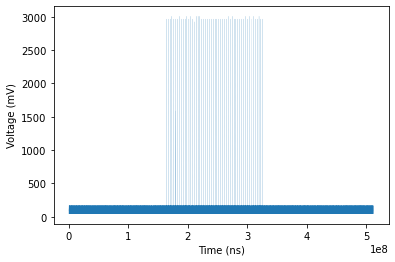

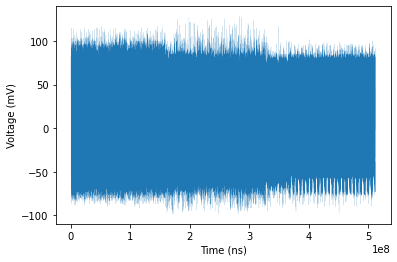

 50%|█████     | 1/2 [00:39<00:39, 39.99s/it]

[d] waiting for response
[d] recieved!
b'\xd6p\xe5\x8e\x03Q\xd8\xae\x8eOn\xac4/\xc21'


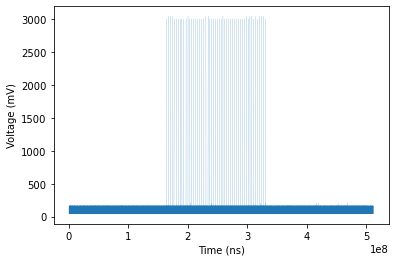

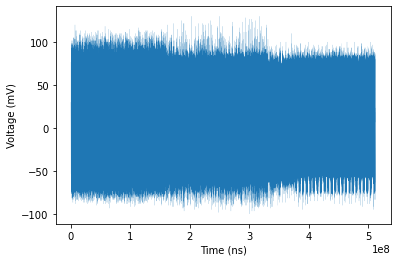

100%|██████████| 2/2 [01:20<00:00, 40.28s/it]


In [9]:
# Step 6: Capturing the data
GET_PC_TRACE = False
# debug view
IS_DEBUG = True
if IS_DEBUG:
    TRACE_NUM = 2
if GET_PC_TRACE:
    pass
else:
    # reset the target for trigger signals, disable for instruction traces
    reset_target()
    # health check
    io.recvuntil(b"READY\n")

# make the result reproducible
random.seed(42)

# collect
print("start collecting...")
for i in tqdm(range(TRACE_NUM)):
    pt = bytes([random.randrange(0, 256) for _ in range(0, PT_LEN)])
    # Setting block capture mode
    status["runblock"] = ps.ps3000aRunBlock(chandle, preTriggerSamples, postTriggerSamples, timebase, 1, None, 0, None, None)
    assert_pico_ok(status["runblock"])
    
    # Setting the data buffer location for data collection from channel A
    source = ps.PS3000A_CHANNEL["PS3000A_CHANNEL_A"]
    ratio_mode = ps.PS3000A_RATIO_MODE["PS3000A_RATIO_MODE_NONE"]
    status["SetDataBuffersA"] = ps.ps3000aSetDataBuffers(chandle, source, ctypes.byref(bufferAMax), ctypes.byref(bufferAMin), maxsamples, 0, ratio_mode)
    assert_pico_ok(status["SetDataBuffersA"])

    # Setting the data buffer location for data collection from channel B
    source = ps.PS3000A_CHANNEL["PS3000A_CHANNEL_B"]
    ratio_mode = ps.PS3000A_RATIO_MODE["PS3000A_RATIO_MODE_NONE"]
    status["SetDataBuffersB"] = ps.ps3000aSetDataBuffers(chandle, source, ctypes.byref(bufferBMax), ctypes.byref(bufferBMin), maxsamples, 0, ratio_mode)
    assert_pico_ok(status["SetDataBuffersB"])

    # Send trigger bytes to the targer MCU, which will pull up a pin after receiving the plaintext
    # send_line(CMD_TINYAES_U)
    # send_line(pt)
    # time.sleep(0.1)
    # data = io.recvuntil(b"DONE\n")                

    # # Send cmd to trigger coremark
    # send_line(CMD_COREMARK_U)
    # time.sleep(0.1)
    # data = io.recvuntil(b"DONE\n")

    # Send cmd to trigger coremark
    send_line(CMD_ECDSA_U)
    print("[d] waiting for response")
    time.sleep(0.1)
    data = io.recvuntil(b"DONE\n")
    print("[d] recieved!")

    # Checks data collection to finish the capture
    ready = ctypes.c_int16(0)
    check = ctypes.c_int16(0) # ?
    while ready.value == check.value:
        status["isReady"] = ps.ps3000aIsReady(chandle, ctypes.byref(ready))

    status["GetValues"] = ps.ps3000aGetValues(chandle, left_shift, ctypes.byref(cmaxSamples), 0, 0, 0, ctypes.byref(overflow))
    assert_pico_ok(status["GetValues"]) # ?

    if IS_SAVE:
        get_text = b"\x00" * 16
        trace_handler_chA.write_one_trace(text=pt+get_text, samples=np.asarray(bufferAMax, dtype=np.int16))
        trace_handler_chB.write_one_trace(text=pt+get_text, samples=np.asarray(bufferBMax, dtype=np.int16))


    ########################## debug lines
    if IS_DEBUG:
        # print plain text
        print(pt)
        # Creates the time data
        times = np.linspace(0, (cmaxSamples.value) * timeIntervalns.value, cmaxSamples.value)

        # Converts ADC from channel A to mV
        adc2mVChAMax = adc2mV(bufferAMax, chARange, maxADC)
        adc2mVChBMax = adc2mV(bufferBMax, chBRange, maxADC)

        # Plots the data from channel A
        plt.figure()
        plt.plot(times, adc2mVChAMax[:], linewidth=0.1)
        plt.xlabel('Time (ns)')
        plt.ylabel('Voltage (mV)')
        plt.show()

        # Plots the data from channel B
        plt.figure()
        plt.plot(times, adc2mVChBMax[:], linewidth=0.1)
        plt.xlabel('Time (ns)')
        plt.ylabel('Voltage (mV)')
        plt.show()
        # plt.figure()
        # plt.plot(times, bufferBMax[:], linewidth=0.1)
        # plt.xlabel('Time (ns)')
        # plt.ylabel('ADC Buffer')
        # plt.show()

        # print(np.asarray(bufferAMax, dtype=np.int16))
        # print(np.asarray(bufferBMax, dtype=np.int16))
    

In [10]:
# Finally, Stop and Close the scope
status["stop"] = ps.ps3000aStop(chandle)
assert_pico_ok(status["stop"])

status["close"] = ps.ps3000aCloseUnit(chandle)
assert_pico_ok(status["close"])

# Displays the staus returns
print(status)

trace_handler_chB.close_write_fid()
trace_handler_chA.close_write_fid()

{'openunit': 0, 'setChA': 0, 'setChB': 0, 'maximumValue': 0, 'GetTimebase': 0, 'trigger': 0, 'runblock': 0, 'SetDataBuffersA': 0, 'SetDataBuffersB': 0, 'isReady': 0, 'GetValues': 0, 'stop': 0, 'close': 0}


In [11]:
raise

RuntimeError: No active exception to reraise

Mannul test

In [ ]:
import ctypes
import serial
from picosdk.ps3000a import ps3000a as ps
from picosdk.functions import mV2adc, adc2mV, assert_pico_ok
import numpy as np
import matplotlib.pyplot as plt
    
from pwn import *
from tqdm import tqdm
import random
import time

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from Trace_processor_pico3000a import TraceProcessor


TRACE_NUM = 1
PORT = "/dev/ttyACM0"
CMD_TINYAES_U = p8(0xA1) # uart tinyaes encryption
CMD_COREMARK_U = p8(0xA2)
CMD_ECDSA_U = p8(0xA3) # ecdsa
PT_LEN = 0x10
GET_PC_TRACE = False

if "io" in globals():
    io.close()

io = serialtube(PORT, baudrate=115200)

def reset_target():
    cmd = 'nrfjprog --reset'
    output_bytes = subprocess.check_output(cmd, shell=True)
    print(output_bytes.decode('utf-8'))

def send_line(bs: bytes):
    # l = len(bs)
    # io.send(p32(l))TRACE_NUM = 10
    io.sendline(bs.hex())

if GET_PC_TRACE:
    pass
else:
    reset_target()

io.recvuntil(b"READY\n")

# generate random plain text
random.seed(42)
pt = [bytes([random.randrange(0, 256) for _ in range(0, PT_LEN)]) for _ in range(TRACE_NUM)]

# collect the traces
while True:
# for i in tqdm(range(TRACE_NUM)):
    # send_line(CMD_TINYAES_U)
    # send_line(CMD_COREMARK_U)
    send_line(CMD_ECDSA_U)
    # send_line(pt[i])
    send_line(pt[0])
    data = io.recvuntil(b"DONE\n")
    # collect_one_trace()
    # print(i, data)
    print("YES!")
    sleep(1)

io.close()
print("All done.")

Applying system reset.
Run.



/tmp/ipykernel_444692/4283850263.py:40: BytesWarning: Text is not bytes; assuming ASCII, no guarantees. See https://docs.pwntools.com/#bytes
  io.sendline(bs.hex())


YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!


KeyboardInterrupt: 

In [ ]:
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad

key = bytearray([0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c])
cipher = AES.new(key, AES.MODE_ECB)
for p in pt:
    print(f"pt: {p.hex()}")
    ct = cipher.encrypt(p)
    print(ct.hex())

pt: 390c8c7d7247342cd8100f2f6f770d65
96e9c46d731b2b260a16e8c40be17552


In [ ]:
pt = bytes([random.randrange(0, 256) for _ in range(0, PT_LEN)]) 
pt_arr = np.array([x for x in pt], dtype='uint8')

print(type(pt_arr[0]))

<class 'numpy.uint8'>


In [ ]:
np.zeros((2,3))

array([[0., 0., 0.],
       [0., 0., 0.]])